# Practica 1. Análisis Predictivo
## Predicción de Ventas de Apple con Modelos ETS y ARIMA
## Isabel Marsa Martin

- ¿Los ingresos de Apple son estacionarios? ¿En media? ¿En varianza?
- ¿Cuál es su tendencia? ¿y su componente estacional?
- ¿Cuales son las ventas anuales de Apple?
- ¿Cuales son los crecimientos anuales de los ingresos?
- ¿Qué modelo predice mejor?
- ¿Existe efecto COVID? Cuantificar.
- ¿Cuales son las ventas acumuladas para el año 2021? ¿Y para el 2022? 
- ¿Son creíbles las predicciones del Barclays?

### Se aplicará la estimación y selección de modelos ETS y ARIMA y se determinará la precisión de las predicciones.


Importamos las librerías:

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

import warnings
warnings.filterwarnings('ignore')

Lectura de los datos:

In [2]:
aapl_df = pd.read_csv('aapl.csv',sep=';',decimal=",")
aapl_df['fecha'] = pd.to_datetime(aapl_df['fecha'],format="%m/%d/%Y")
aapl_df.head()


,Trimeste,fecha,Ingresos
0,Q1 1990,1989-12-29,1493.4
1,Q2 1990,1990-03-30,1346.2
2,Q3 1990,1990-06-29,1364.8
3,Q4 1990,1990-09-28,1354.1
4,Q1 1991,1990-12-28,1675.5


Teniendo en cuenta que el año fiscal de Apple empieza en octubre, añadiré 7 días en la variable fecha. La función resample entiende año natural por lo que haré esto para que al utilizar esta función más adelante, se identifique cada fecha con su trimestre correspondiente y así pueda hacer un análisis correcto:

In [3]:
import datetime
aapl_df['fecha']=aapl_df['fecha']+datetime.timedelta(days=7)

In [4]:
#Fijamos la fecha como índice
aapl_df = aapl_df.set_index('fecha')

In [5]:
# Observamos si hay datos missing
len(aapl_df[pd.isna(aapl_df.Ingresos)])

0

In [6]:
# Analisis inicial del dataset
aapl_df.info()
#datos trimestrales desde el 1T de 1990 hasta el 2T del 2021
#tenemos que predecir los ingresos del resto del año 2021 y del 2022 (6 trimestres)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 1990-01-05 to 2021-07-03
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Trimeste  127 non-null    object 
 1   Ingresos  127 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.0+ KB


In [7]:
aapl_df.describe()

,Ingresos
count,127.000000
mean,21170.611811
std,27187.105328
min,1007.000000
25%,1726.500000
50%,3520.000000
75%,42240.500000
max,111439.000000


In [8]:
# Me quedo con la variable Ingresos
aapl_df=aapl_df["Ingresos"]

In [12]:
# Convertimos en trimestrales los datos de la variable ingresos
aapl_dfs=aapl_df.resample("q").last()
aapl_dfs.tail()

fecha
2020-09-30     59685.0
2020-12-31     64698.0
2021-03-31    111439.0
2021-06-30     89584.0
2021-09-30     81434.0
Freq: Q-DEC, Name: Ingresos, dtype: float64

In [13]:
len(aapl_dfs[pd.isna(aapl_dfs)])

1

In [14]:
# Quito los NAs remplazandolos por la media de ingresos
aapl_dfs=aapl_dfs.fillna(aapl_dfs.median())

In [21]:
# Resample to Quarterly II
# SKtime 
aapl_dfsq=aapl_df.astype('float64').to_period('Q').sort_index()
aapl_dfsq.tail()

fecha
2020Q3     59685.0
2020Q4     64698.0
2021Q1    111439.0
2021Q2     89584.0
2021Q3     81434.0
Freq: Q-DEC, Name: Ingresos, dtype: float64

In [22]:
# Quito una fila repetida (Q12022)
aapl_dfsq = aapl_dfsq[~aapl_dfsq.index.duplicated(keep='first')]

In [24]:
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})


In [25]:
#Usando Sktime
from sktime.utils.plotting import plot_series

Text(0.5, 1.0, 'Ventas Apple: Serie Original')

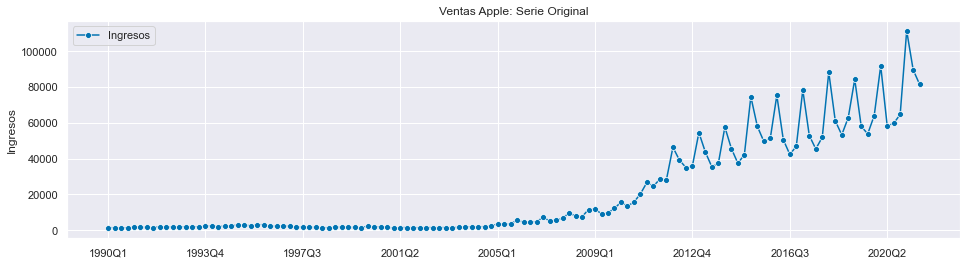

In [26]:
plot_series(aapl_dfsq, labels=["Ingresos"])
plt.title('Ventas Apple: Serie Original')

Text(0.5, 1.0, 'Comportamiento Estacional')

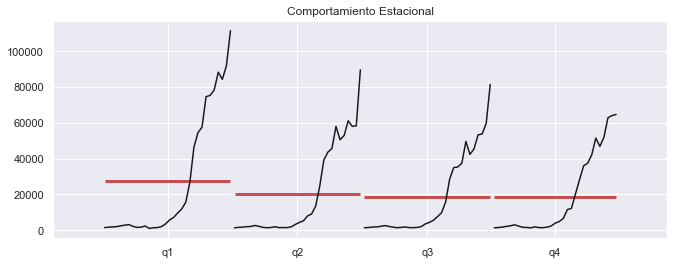

In [27]:
# Gráfico estacional
ax = plt.gca()
sm.graphics.tsa.quarter_plot(aapl_dfs,ax=ax)
ax.set_title('Comportamiento Estacional')

In [28]:
# Log Transformer
from sktime.transformations.series.boxcox import LogTransformer

In [29]:
# Aplico Log Transformer para estabilizar la varianza de los datos y normalizarlos
# Transformacion log aplicada como ln(y)
transformer = LogTransformer()
log_ap_ts= transformer.fit_transform(aapl_dfsq)
log_ap_ts.tail()

2020Q3    10.996836
2020Q4    11.077486
2021Q1    11.621233
2021Q2    11.402932
2021Q3    11.307548
Freq: Q-DEC, dtype: float64

#### ETS Models

A continuación seleccionaremos la muestra de entrenamiento (train) y test. Intentaremos predecir y_test y haremos un gráfico con los datos originales y transformados (log).

In [30]:
# Sktime 
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split

118 8


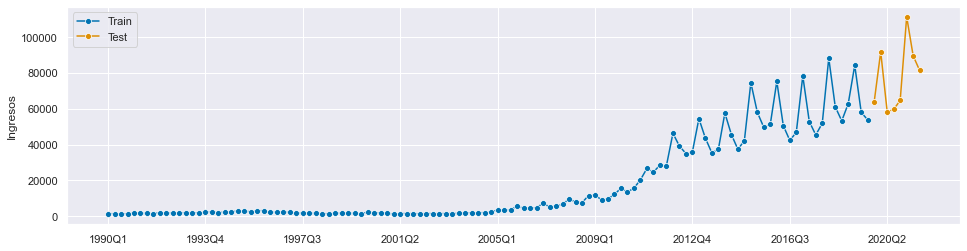

In [31]:
n_test=8
n_forecast=8
y_train, y_test = temporal_train_test_split(y =aapl_dfsq, test_size=8)
log_y_train, log_y_test = temporal_train_test_split(y =log_ap_ts, test_size=n_test)
plot_series(y_train, y_test, labels=["Train", "Test"])

# Tamaño Time Series
print(y_train.shape[0], y_test.shape[0])


In [32]:
from sktime.forecasting.ets import AutoETS

In [34]:
# horizonte de prediccion
fh= np.arange(len(y_test)) + 1

In [35]:
# especificamos el algoritmo de prediccion - AutoETS
ap_autoETS_model = AutoETS(auto=True, sp=4, n_jobs=-1) #4 periodos de estacionalidad

In [36]:
ap_autoETS_model.fit(y_train)

AutoETS(auto=True, n_jobs=-1, sp=4)

In [38]:
print(ap_autoETS_model.summary())

                                 ETS Results                                  
Dep. Variable:               Ingresos   No. Observations:                  118
Model:                       ETS(MAM)   Log Likelihood                -966.643
Date:                Mon, 10 Oct 2022   AIC                           1953.287
Time:                        13:44:50   BIC                           1980.994
Sample:                    03-31-1990   HQIC                          1964.537
                         - 09-30-2019   Scale                            0.020
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.4453      0.061      7.335      0.000       0.326       0.564
smoothing_trend        0.1696      0.036      4.720      0.000       0.099       0.240
smoothing_seasonal  

In [39]:
ap_ETS_pred = ap_autoETS_model.predict(fh)
print(ap_ETS_pred)

2019Q4    86030.366600
2020Q1    59917.127492
2020Q2    53254.895213
2020Q3    58507.036792
2020Q4    85956.439438
2021Q1    59865.628757
2021Q2    53209.112826
2021Q3    58456.728409
Freq: Q-DEC, dtype: float64


Text(0.5, 1.0, 'Prediccion Ventas con ETS')

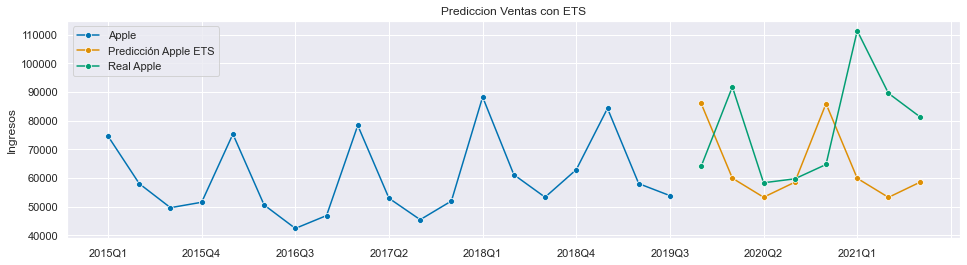

In [40]:
fig, ax= plot_series(y_train["2015":], ap_ETS_pred,y_test, labels=["Apple", "Predicción Apple ETS", "Real Apple"])
ax.set_title('Prediccion Ventas con ETS')

#### ARIMA

In [43]:
from sktime.forecasting.arima import AutoARIMA

In [44]:
#Auto ARIMA 
forecaster = AutoARIMA(sp=4,suppress_warnings=True)

In [45]:
forecaster.fit(log_y_train)

AutoARIMA(sp=4, suppress_warnings=True)

In [46]:
print(forecaster.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  118
Model:             SARIMAX(2, 1, 3)x(1, 0, [1], 4)   Log Likelihood                  55.826
Date:                             Mon, 10 Oct 2022   AIC                            -95.652
Time:                                     13:45:57   BIC                            -73.554
Sample:                                 03-31-1990   HQIC                           -86.680
                                      - 09-30-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3007      0.062     -4.865      0.000      -0.422      -0.180
ar.L2         -0.9798      

In [47]:
#Auto ARIMA Forecast LOG
log_y_pred = forecaster.predict(fh)
log_y_pred

2019Q4    11.312125
2020Q1    11.023250
2020Q2    10.969271
2020Q3    11.034301
2020Q4    11.324394
2021Q1    11.085722
2021Q2    11.023245
2021Q3          NaN
Freq: Q-DEC, dtype: float64

In [48]:
# Predicción Auto ARIMA 
ap_ARIMA_pred=np.exp(log_y_pred)
ap_ARIMA_pred

2019Q4    81807.579727
2020Q1    61282.550586
2020Q2    58062.224079
2020Q3    61963.492529
2020Q4    82817.464041
2021Q1    65233.082536
2021Q2    61282.195539
2021Q3             NaN
Freq: Q-DEC, dtype: float64

Text(0.5, 1.0, 'Predicción con ARIMA')

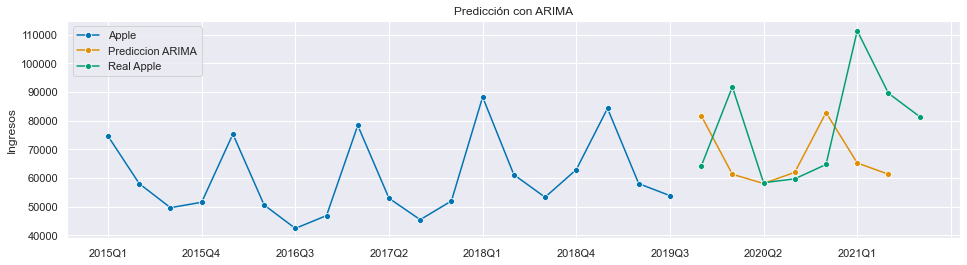

In [49]:
fig, ax=plot_series(y_train["2015":], ap_ARIMA_pred,y_test, labels=["Apple", "Prediccion ARIMA", "Real Apple"])
ax.set_title('Predicción con ARIMA')

Text(0.5, 1.0, 'Comparación Modelos ETS y ARIMA')

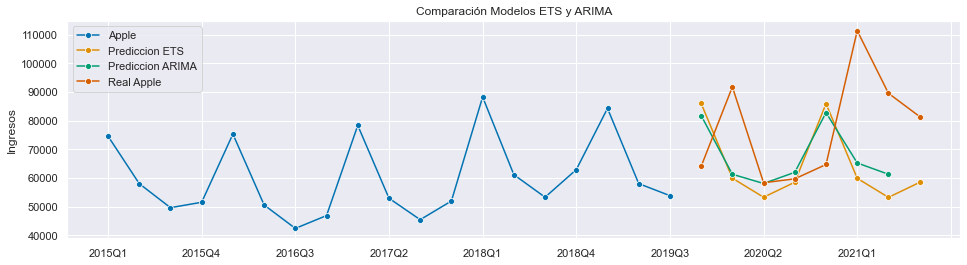

In [50]:
# Comparación modelos ETS y ARIMA
fig,ax=plot_series(y_train["2015":], ap_ETS_pred,ap_ARIMA_pred,y_test, labels=['Apple', 'Prediccion ETS','Prediccion ARIMA', 'Real Apple'])
ax.set_title('Comparación Modelos ETS y ARIMA')

In [51]:
prediccion=pd.concat([y_test,ap_ETS_pred,ap_ARIMA_pred],axis=1)
prediccion.columns=["APPLE", 'ETS','ARIMA']
prediccion
#NaN el 2021Q3

,APPLE,ETS,ARIMA
2019Q4,64040.0,86030.366600,81807.579727
2020Q1,91819.0,59917.127492,61282.550586
2020Q2,58313.0,53254.895213,58062.224079
2020Q3,59685.0,58507.036792,61963.492529
2020Q4,64698.0,85956.439438,82817.464041
2021Q1,111439.0,59865.628757,65233.082536
2021Q2,89584.0,53209.112826,61282.195539
2021Q3,81434.0,58456.728409,NaN


In [52]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError

In [57]:
##ETS
#Precision: MAPE

mean_absolute_percentage_error(y_test, ap_ETS_pred)

0.2846099326241587

In [58]:
#Remplazo el nan por la mediana de los datos
ap_ARIMA_pred=ap_ARIMA_pred.fillna(ap_ARIMA_pred.median())

In [59]:
## ARIMA
#Precision: MAPE
mean_absolute_percentage_error(y_test, ap_ARIMA_pred)

0.23777565939474082

In [60]:
##ETS
#Precision: MSE
rmse = MeanSquaredError(square_root=True)
rmse(y_test, ap_ETS_pred)

28484.86222875093

In [72]:
ap_ARIMA_pred=ap_ARIMA_pred.fillna(ap_ARIMA_pred.median())

In [73]:
##ARIMA
#Precision: MAPE
rmse = MeanSquaredError(square_root=True)
rmse(y_test, ap_ARIMA_pred)

24740.68165919816

In [61]:
#ETS Modelo
fh = np.arange(1, 7)
ap_ETS_model = AutoETS(auto=True, sp=4, n_jobs=-1) 
ap_ETS_model.fit(aapl_dfsq) 
print(ap_ETS_model.summary())

                                 ETS Results                                  
Dep. Variable:               Ingresos   No. Observations:                  126
Model:                       ETS(MAM)   Log Likelihood               -1050.949
Date:                Mon, 10 Oct 2022   AIC                           2121.898
Time:                        13:47:54   BIC                           2150.261
Sample:                    03-31-1990   HQIC                          2133.421
                         - 09-30-2021   Scale                            0.020
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.4521      0.061      7.418      0.000       0.333       0.572
smoothing_trend        0.1717      0.036      4.771      0.000       0.101       0.242
smoothing_seasonal  

In [75]:
# ETS
ap_ETS_pred = ap_ETS_model.predict(fh) 
print(ap_ETS_pred)

2021Q4    153775.649432
2022Q1    111698.002193
2022Q2    104005.517590
2022Q3    119908.805341
2022Q4    191504.631418
2023Q1    137519.375077
Freq: Q-DEC, dtype: float64


In [76]:
# ETS Modelo
fh = np.arange(1, 7)
ap_ETS_model = AutoETS(auto=True, sp=4, n_jobs=-1) 
ap_ETS_model.fit(aapl_dfsq) 
print(ap_ETS_model.summary())

                                 ETS Results                                  
Dep. Variable:               Ingresos   No. Observations:                  126
Model:                       ETS(MAM)   Log Likelihood               -1050.949
Date:                Mon, 10 Oct 2022   AIC                           2121.898
Time:                        13:18:08   BIC                           2150.261
Sample:                    03-31-1990   HQIC                          2133.421
                         - 09-30-2021   Scale                            0.020
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.4521      0.061      7.418      0.000       0.333       0.572
smoothing_trend        0.1717      0.036      4.771      0.000       0.101       0.242
smoothing_seasonal  

In [77]:
# ETS Forecast
ap_ETS_pred = ap_ETS_model.predict(fh) 
print(ap_ETS_pred)

2021Q4    153775.649432
2022Q1    111698.002193
2022Q2    104005.517590
2022Q3    119908.805341
2022Q4    191504.631418
2023Q1    137519.375077
Freq: Q-DEC, dtype: float64


In [62]:
#ARIMA
ap_ARIMA_Model = AutoARIMA(sp=4,suppress_warnings=True) 
ap_ARIMA_Model.fit(log_ap_ts) 
print(ap_ARIMA_Model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  126
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 4)   Log Likelihood                  57.028
Date:                           Mon, 10 Oct 2022   AIC                           -106.057
Time:                                   13:48:59   BIC                            -94.744
Sample:                               03-31-1990   HQIC                          -101.461
                                    - 09-30-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3445      0.083     -4.164      0.000      -0.507      -0.182
ar.S.L4        0.9343      0.055     16.932

## PREGUNTAS:

### Pregunta 1 y 2. Estacionariedad, tendencia y componente estacional

In [ ]:
# Plot Data
fig, ax =plot_series(aapl_dfsq, labels=["Ventas"])
ax.set_title('Ventas Apple: Gráfico Original')
ax.legend(loc='upper left')
ax.set_ylabel('Ventas')

In [ ]:
# Plot Log Data
fig, ax =plot_series(log_ap_ts, labels=["Ventas"])
ax.set_title('Ventas Apple: Transformación Log')
ax.legend(loc='upper left')
ax.set_ylabel('Ventas')

In [ ]:
from statsmodels.tsa.seasonal import STL 
res = STL(aapl_dfs).fit()
res.plot()
plt.show()

### Pregunta 3. Ventas anuales de Apple

In [ ]:
ap_year=aapl_dfsq.resample('y').sum() 
ap_year.tail(10)
print('Ventas Anuales de Apple los Últimos 10 Años:')
ap_year.tail(10)

v=pd.DataFrame(ap_year.tail(10))
v

### Pregunta 4. Crecimientos anuales de los ingresos

In [ ]:
c=pd.DataFrame (ap_year.pct_change().tail(10))
c2=c.rename(columns={'Ingresos':'Crecimiento'})

In [ ]:
concat = pd.concat([v, c2], axis=1,)
concat
concat

### Pregunta 5. Qué modelo predice mejor

### Pregunta 6. Efecto COVID

### Pregunta 7. ventas acumuladas para el año 2021 y 2022


In [86]:
print('Ventas acumuladas para el año 2021, 2022 y 2023 con ETS')
pd.DataFrame(pd.concat([aapl_dfsq,ap_ETS_pred],axis=0).resample('A').sum()['2021':])

Ventas acumuladas para el año 2021, 2022 y 2023 con ETS


,0
2021,436232.649432
2022,527116.956541
2023,137519.375077


In [87]:
print('Ventas acumuladas para el año 2021 Y 2022 con ARIMA')
pd.DataFrame(pd.concat([aapl_dfsq,ap_ARIMA_pred],axis=0).resample('A').sum()['2021':])


Ventas acumuladas para el año 2021 Y 2022 con ARIMA


,0
2021,470935.770605


### Pregunta 9. ¿Son creíbles las predicciones del Barclays?